In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import DarkNews as dn

from DarkNews import const

from DarkNews.GenLauncher import GenLauncher

from DarkNews import Cfourvec as Cfv

In [4]:
# Testing the VEGAS integration methods:
import vegas as vg
from collections import OrderedDict

class test_integral(vg.BatchIntegrand):

    def __init__(self, dim, c = 1):
        self.dim = dim	
        self.c = c
        self.analytical_func = lambda x: np.exp(self.c * x) * (self.c*x-1)/self.c**2
        self.analytical_res  = (self.analytical_func(2) - self.analytical_func(0))

        # initialize
        self.norm = {'diff_xsec': 1, 'diff_xsec2': 1}
        # normalize integrand with an initial throw
        _throw = self.__call__(np.random.rand(dim,500), np.ones((dim,500)))
        for key,val in _throw.items():
            self.norm[key] = np.mean(val)
    
    def __call__(self, x, jac):

        xmax = 2
        xmin = 0
        xx=np.empty(0)
        diff = 1
        diff2 = 1
        for d in range(self.dim):
            xx = x[:,d]*(xmax - xmin) + xmin
            diff *= np.exp(self.c*xx)*xx
            if d < self.dim - 2:
                diff2 *= np.exp(self.c*xx)*xx

        # hypercube jacobian (vegas hypercube --> physical limits) transformation
        hypercube_jacobian = (xmax - xmin)
        diff  *= hypercube_jacobian**self.dim
        diff2 *= hypercube_jacobian**(self.dim)

        ##############################################
        # return all differential quantities of interest
        self.int_dic = OrderedDict()		
        self.int_dic['diff_xsec'] = diff
        self.int_dic['diff_xsec2'] = diff2
        
        ##############################################
        # storing normalization for integrands to be of O(1) numbers		
        # normalization
        for key in self.int_dic:
            self.int_dic[key] /= self.norm[key]
        self.int_dic['diff_xsec2'] /= jac[:,-1]*jac[:,-2]
        return self.int_dic

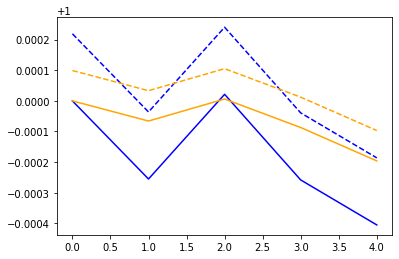

In [5]:
evals = []
evals2 = []
for i in range(5):
    #########################################################################
    # BATCH SAMPLE INTEGRAND OF INTEREST
    DIM = 6
    batch_f = test_integral(dim=DIM)
    integ = vg.Integrator(DIM*[[0.0, 1.0]]) # unit hypercube
    result = dn.MC.run_vegas(batch_f, integ, NINT=20, NEVAL=10000, NINT_warmup=20, NEVAL_warmup=1000)
    ##########################################################################
    # print(result.summary())
    evals.append(result['diff_xsec'].mean*batch_f.norm['diff_xsec'])
    evals2.append(result['diff_xsec2'].mean*batch_f.norm['diff_xsec2'])

plt.plot(evals/evals[0], color='blue')
plt.plot(evals/batch_f.analytical_res**DIM, ls='--', color='blue')
plt.plot(evals2/evals2[0], color='orange')
plt.plot(evals2/batch_f.analytical_res**(DIM-2)/4, ls='--', color='orange')


In [6]:
samples, weights, jac = dn.MC.get_samples(integ, batch_f, return_jac=True)

In [7]:
np.sum(weights['diff_xsec'])*batch_f.norm['diff_xsec']/batch_f.analytical_res**DIM


0.9994209667547962

In [8]:
np.sum(weights['diff_xsec'])*batch_f.norm['diff_xsec']/batch_f.analytical_res**(DIM)


0.9994209667547962

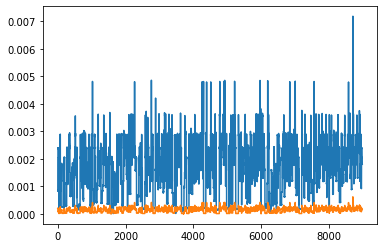

In [9]:
for key,vals in weights.items():
    plt.plot(vals)

In [10]:
(weights['diff_xsec2']*jac[:,5]).sum()


1.170356823708281

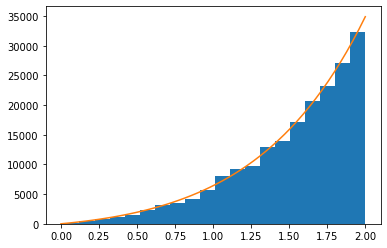

In [11]:
bins = 20

_ = plt.hist(samples[0,:]*2, weights=weights['diff_xsec2']*batch_f.norm['diff_xsec2']/(2/bins), bins=bins, density=False)

x=np.linspace(0,2)

plt.plot(x, np.exp(batch_f.c * x)*x * batch_f.analytical_res**(DIM-3)*4)


# profile amplitude calculation

In [12]:
proton = dn.detector.NuclearTarget("H1")
bsm_model = dn.model.create_model(mzprime=0.1, m4 = 0.01, Umu4=1e-3)
calculator = dn.MC.XsecCalc(bsm_model = bsm_model, scattering_regime = 'p-el', nuclear_target= proton, helicity = 'conserving')

Model:
	1 majorana heavy neutrino(s).
	kinetically mixed Z'


In [13]:
one = np.ones(1000)
%prun dn.amplitudes.upscattering_dxsec_dQ2([one,one,one], calculator.ups_case)

         27 function calls in 0.001 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.001    0.001    0.001    0.001 amplitudes.py:16(upscattering_dxsec_dQ2)
        6    0.000    0.000    0.000    0.000 nuclear_tools.py:275(D)
        1    0.000    0.000    0.000    0.000 nuclear_tools.py:280(nucleon_F1_EM)
        1    0.000    0.000    0.001    0.001 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 nuclear_tools.py:286(nucleon_F2_EM)
        1    0.000    0.000    0.000    0.000 nuclear_tools.py:299(nucleon_F2_NC)
        1    0.000    0.000    0.000    0.000 nuclear_tools.py:294(nucleon_F1_NC)
        5    0.000    0.000    0.000    0.000 const.py:313(Sqrt)
        1    0.000    0.000    0.000    0.000 const.py:293(kallen)
        1    0.000    0.000    0.001    0.001 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 nuclear_tools.py:304(nucleon_F3_NC)
        1

# profile full generation

In [14]:
ud4_def = 1.0
alphaD = 0.25
gD_def = np.sqrt(alphaD*4*np.pi)
umu4_def = np.sqrt(9e-7)
ud4 = 1.
epsilon_def = np.sqrt(2e-10/const.alphaQED)

gen = GenLauncher(mzprime=0.03, m4=0.420, epsilon=epsilon_def, Umu4=umu4_def, UD4=ud4_def, gD=gD_def, neval=100, HNLtype="dirac", exp="miniboone_fhc", loglevel='ERROR')
gen.run(log="ERROR")
df_mini = gen.df

Model:
	1 dirac heavy neutrino(s).
	kinetically mixed Z'
Experiment:
	MiniBooNE_FHC
	fluxfile loaded: ../fluxes/MiniBooNE_FHC.dat
	POT: 1.875e+21
	nuclear targets: ['C12', 'H1']
	fiducial mass: [701.1428571428571, 116.85714285714286] tonnes


In [15]:
%prun gen.run(log="ERROR")

         980603 function calls (963064 primitive calls) in 1.776 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      204    0.282    0.001    0.545    0.003 amplitudes.py:16(upscattering_dxsec_dQ2)
        6    0.205    0.034    1.257    0.210 MC.py:461(run_vegas)
        6    0.094    0.016    1.716    0.286 MC.py:194(get_MC_events)
     8908    0.048    0.000    0.048    0.000 {method 'reduce' of 'numpy.ufunc' objects}
     1284    0.044    0.000    0.093    0.000 _decomp.py:267(eigh)
     7148    0.043    0.000    0.105    0.000 core.py:2972(__array_finalize__)
27495/17918    0.039    0.000    0.176    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
      480    0.037    0.000    0.243    0.001 {scipy.sparse.csgraph._tools.csgraph_from_dense}
    10616    0.034    0.000    0.053    0.000 core.py:2946(_update_from)
      204    0.031    0.000    0.673    0.003 integrands.py:113(__call__)
  

In [13]:
df_mini.w_event_rate.sum()*0.05


546.707134653041

In [14]:
gen = GenLauncher(mzprime=0.03, m4=0.420, epsilon=epsilon_def, Umu4=umu4_def, UD4=ud4_def, gD=gD_def, neval=1000, HNLtype="dirac", exp="microboone", loglevel='ERROR')
gen.run(log="ERROR")
df_micro = gen.df

In [68]:
ud4_def = 1.0
alphaD = 0.4
gD_def = np.sqrt(alphaD*4*np.pi)
umu4_def = 4e-4
umu5_def = 4e-4
ud4 = 1.
ud5 = 1.
epsilon_def = 2.2e-2

gen = GenLauncher(mzprime=1.25, m4=0.010, m5=0.490, epsilon=epsilon_def, Umu4=umu4_def, Umu5=umu5_def, UD4=ud4_def, UD5=ud5, gD=gD_def, neval=10000, HNLtype="majorana", exp="miniboone_fhc", loglevel='ERROR')
gen.run(log="ERROR")
df_mini = gen.df

gen = GenLauncher(mzprime=1.25, m4=0.010, m5=0.490, epsilon=epsilon_def, Umu4=umu4_def, Umu5=umu5_def, UD4=ud4_def, UD5=ud5, gD=gD_def, neval=10000, HNLtype="majorana", exp="microboone", loglevel='ERROR')
gen.run(log="ERROR")
df_micro = gen.df

In [69]:

ud4_def = 1.0
alphaD = 0.4
gD_def = np.sqrt(alphaD*4*np.pi)
umu4_def = 4e-4
umu5_def = 4e-4
ud4 = 1.
ud5 = 1.
epsilon_def = 2.2e-2

gen = GenLauncher(mzprime=1.25, m4=0.010, epsilon=0.0, dmu4= 1e-6, gD=0.0, neval=10000, HNLtype="dirac", exp="miniboone_fhc", loglevel='ERROR')
gen.run(log="ERROR")
df_mini = gen.df


In [73]:
df_mini

P_projectile                       P_target                          \
                0    1    2         3          0    1    2             3   
0        0.129569  0.0  0.0  0.129569  11.174864 -0.0 -0.0  7.405188e-14   
1        0.312441  0.0  0.0  0.312441  11.174864 -0.0 -0.0  2.009504e-14   
2        0.201090  0.0  0.0  0.201090  11.174864 -0.0 -0.0  6.541989e-14   
3        0.189731  0.0  0.0  0.189731  11.174864 -0.0 -0.0 -2.017830e-14   
4        0.384020  0.0  0.0  0.384020  11.174864 -0.0 -0.0  3.474998e-14   
...           ...  ...  ...       ...        ...  ...  ...           ...   
8967     1.058476  0.0  0.0  1.058476  11.174864 -0.0 -0.0 -1.887379e-15   
8968     1.174999  0.0  0.0  1.174999  11.174864 -0.0 -0.0 -1.332268e-15   
8969     1.119615  0.0  0.0  1.119615  11.174864 -0.0 -0.0 -1.287859e-14   
8970     1.184645  0.0  0.0  1.184645  11.174864 -0.0 -0.0  6.661338e-15   
8971     1.398671  0.0  0.0  1.398671  11.174864 -0.0 -0.0  9.103829e-15   

       P_recoil            ... w_flux_avg_xsec target target_pdgid  \
              0         1  ...                                       
0     11.174899 -0.019877  ...    1.068755e-05    C12   1000060120   
1     11.175011 -0.041313  ...    2.514613e-05    C12   1000060120   
2     11.174910  0.031726  ...    1.554039e-05    C12   1000060120   
3     11.174897  0.009316  ...    1.654636e-05    C12   1000060120   
4     11.174948 -0.032219  ...    3.343148e-05    C12   1000060120   
...         ...       ...  ...             ...    ...          ...   
8967  11.179451 -0.060938  ...    4.415715e-07    C12   1000060120   
8968  11.177260  0.084558  ...    4.259296e-05    C12   1000060120   
8969  11.186188  0.404706  ...    4.048295e-07    C12   1000060120   
8970  11.176646 -0.150747  ...    7.773266e-05    C12   1000060120   
8971  11.190326 -0.253902  ...    1.408065e-10    C12   1000060120   

     scattering_regime    helicity  \
                                     
0             coherent  conserving   
1             coherent  conserving   
2             coherent  conserving   
3             coherent  conserving   
4             coherent  conserving   
...                ...         ...   
8967          coherent  conserving   
8968          coherent  conserving   
8969          coherent  conserving   
8970          coherent  conserving   
8971          coherent  conserving   

                                     underlying_process pos_decay              \
                                                                0           1   
0     nu(mu) + C12 -> N4 +  C12 -> nu_light + e+ + e...       0.0 -259.385763   
1     nu(mu) + C12 -> N4 +  C12 -> nu_light + e+ + e...       0.0 -341.625328   
2     nu(mu) + C12 -> N4 +  C12 -> nu_light + e+ + e...       0.0  162.041268   
3     nu(mu) + C12 -> N4 +  C12 -> nu_light + e+ + e...       0.0  476.453110   
4     nu(mu) + C12 -> N4 +  C12 -> nu_light + e+ + e...       0.0 -440.230046   
...                                                 ...       ...         ...   
8967  nu(mu) + C12 -> N4 +  C12 -> nu_light + e+ + e...       0.0   83.144614   
8968  nu(mu) + C12 -> N4 +  C12 -> nu_light + e+ + e...       0.0 -470.817563   
8969  nu(mu) + C12 -> N4 +  C12 -> nu_light + e+ + e...       0.0 -222.056293   
8970  nu(mu) + C12 -> N4 +  C12 -> nu_light + e+ + e...       0.0  185.928881   
8971  nu(mu) + C12 -> N4 +  C12 -> nu_light + e+ + e...       0.0  101.805653   

                              
               2           3  
0     -99.917017  171.039157  
1     136.283844 -129.587605  
2    -523.011068  -38.314631  
3    -109.619217  -39.310322  
4     -98.135495 -192.891782  
...          ...         ...  
8967 -521.754965  166.224359  
8968  -68.643831  221.291984  
8969   36.255688  269.985272  
8970  -50.972337  432.409118  
8971  -27.459029   85.125695  

[8972 rows x 44 columns]

In [70]:
print(f"event rate Mini {df_micro['w_event_rate'].sum()*0.05}")
print(f"event rate Micro {df_micro['w_event_rate'].sum()*0.05*87/818*(550/470)**2*6/18.75}")

event rate Mini 29.774356538937713
event rate Micro 1.3876756734691589


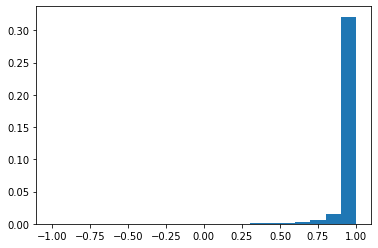

In [72]:
x = Cfv.get_cosTheta((df_mini['P_decay_ell_minus']+df_mini['P_decay_ell_plus']).to_numpy())
w = df_mini['w_event_rate'].to_numpy()
_ = plt.hist(x, weights=w, bins=np.linspace(-1,1,21))

In [15]:

print(f"event rate Mini {df_mini['w_event_rate'].sum()*0.05}")
print(f"event rate Micro rescaled {df_mini['w_event_rate'].sum()*87/818*(550/470)**2*6/18.75}")
print(f"event rate Micro {df_micro['w_event_rate'].sum()*0.5}")
print(f"event rate SBND {df_micro['w_event_rate'].sum()*112/87*(470/110)**2*0.5}")
print(f"event rate Icarus {df_micro['w_event_rate'].sum()*476/87*(470/600)**2*0.5}")

event rate Mini 546.707134653041
event rate Micro rescaled 509.601065788218
event rate Micro 814.2123051149849
event rate SBND 19135.80678102861
event rate Icarus 2733.496843651101


In [18]:
from DarkNews import Cfourvec as Cfv

In [19]:

Cfv.get_cosTheta(df_micro['P_decay_ell_minus'].to_numpy)


TypeError: Argument 'x' has incorrect type (expected numpy.ndarray, got method)

In [133]:
ud4_def = 1.0
alphaD = 0.25
gD_def = np.sqrt(alphaD*4*np.pi)
umu4_def = np.sqrt(9e-8)
ud4 = 1.
epsilon_def = np.sqrt(2e-10/const.alphaQED)

gen = GenLauncher(mzprime=0.03, m4=0.100, epsilon=epsilon_def, Umu4=umu4_def, UD4=ud4_def, gD=gD_def, neval=10000, HNLtype="dirac", exp="miniboone_fhc", loglevel='ERROR')
gen.run(log="ERROR")

P_projectile                       P_target                          \
                0    1    2         3          0    1    2             3   
0        0.190038  0.0  0.0  0.190038  11.174864 -0.0 -0.0  1.651457e-14   
1        0.289007  0.0  0.0  0.289007  11.174864 -0.0 -0.0 -3.491651e-14   
2        0.145159  0.0  0.0  0.145159  11.174864 -0.0 -0.0  2.386980e-15   
3        0.314169  0.0  0.0  0.314169  11.174864 -0.0 -0.0  2.131628e-14   
4        0.276813  0.0  0.0  0.276813  11.174864 -0.0 -0.0  8.160139e-15   
...           ...  ...  ...       ...        ...  ...  ...           ...   
9304     3.055973  0.0  0.0  3.055973  11.174864 -0.0 -0.0 -6.217249e-15   
9305     1.539794  0.0  0.0  1.539794  11.174864 -0.0 -0.0 -1.110223e-14   
9306     2.024895  0.0  0.0  2.024895  11.174864 -0.0 -0.0 -1.998401e-15   
9307     1.614449  0.0  0.0  1.614449  11.174864 -0.0 -0.0  4.440892e-15   
9308     3.739775  0.0  0.0  3.739775  11.174864 -0.0 -0.0  1.332268e-15   

       P_recoil            ... w_flux_avg_xsec target target_pdgid  \
              0         1  ...                                       
0     11.174910 -0.000373  ...        3.108943    C12   1000060120   
1     11.174886 -0.006573  ...        2.689469    C12   1000060120   
2     11.174943  0.007900  ...        2.838396    C12   1000060120   
3     11.174883  0.001626  ...        2.570912    C12   1000060120   
4     11.174883  0.007124  ...        2.588221    C12   1000060120   
...         ...       ...  ...             ...    ...          ...   
9304  11.176726  0.198193  ...        0.289754    C12   1000060120   
9305  11.175246 -0.083122  ...        1.016981    C12   1000060120   
9306  11.175069  0.067398  ...        1.112985    C12   1000060120   
9307  11.175074 -0.043609  ...        1.068187    C12   1000060120   
9308  11.175986  0.158084  ...        0.604945    C12   1000060120   

     scattering_regime    helicity  \
                                     
0             coherent  conserving   
1             coherent  conserving   
2             coherent  conserving   
3             coherent  conserving   
4             coherent  conserving   
...                ...         ...   
9304          coherent  conserving   
9305          coherent  conserving   
9306          coherent  conserving   
9307          coherent  conserving   
9308          coherent  conserving   

                                     underlying_process pos_decay              \
                                                                0           1   
0     nu(mu) + C12 -> N4 +  C12 -> nu_light + e+ + e...       0.0  226.068716   
1     nu(mu) + C12 -> N4 +  C12 -> nu_light + e+ + e...       0.0 -202.415048   
2     nu(mu) + C12 -> N4 +  C12 -> nu_light + e+ + e...       0.0 -272.808991   
3     nu(mu) + C12 -> N4 +  C12 -> nu_light + e+ + e...       0.0  109.974179   
4     nu(mu) + C12 -> N4 +  C12 -> nu_light + e+ + e...       0.0 -245.651802   
...                                                 ...       ...         ...   
9304  nu(mu) + C12 -> N4 +  C12 -> nu_light + e+ + e...       0.0  102.829591   
9305  nu(mu) + C12 -> N4 +  C12 -> nu_light + e+ + e...       0.0 -145.989850   
9306  nu(mu) + C12 -> N4 +  C12 -> nu_light + e+ + e...       0.0  496.428241   
9307  nu(mu) + C12 -> N4 +  C12 -> nu_light + e+ + e...       0.0 -268.294909   
9308  nu(mu) + C12 -> N4 +  C12 -> nu_light + e+ + e...       0.0 -314.928057   

                              
               2           3  
0    -151.560926  204.468353  
1    -314.048954  428.972699  
2     402.869659   53.153963  
3     240.116428 -391.482461  
4    -129.634530 -268.868159  
...          ...         ...  
9304 -431.178860   22.196458  
9305 -272.474554  317.259585  
9306   24.351091   70.861402  
9307 -419.480158 -119.331625  
9308 -334.114586 -104.032701  

[9309 rows x 45 columns]

In [134]:
gen_m = GenLauncher(mzprime=0.03, m4=0.100, epsilon=epsilon_def, Umu4=umu4_def, UD4=ud4_def, gD=gD_def, neval=10000, HNLtype="majorana", exp="miniboone_fhc", loglevel='ERROR')
gen_m.run(log="ERROR")

/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")
/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")
/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")
/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")
/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas res

P_projectile                       P_target                          \
                0    1    2         3          0    1    2             3   
0        0.206332  0.0  0.0  0.206332  11.174864 -0.0 -0.0 -6.372680e-14   
1        0.248673  0.0  0.0  0.248673  11.174864 -0.0 -0.0  1.154632e-14   
2        0.295985  0.0  0.0  0.295985  11.174864 -0.0 -0.0 -3.902434e-14   
3        0.184638  0.0  0.0  0.184638  11.174864 -0.0 -0.0 -2.242651e-14   
4        0.200846  0.0  0.0  0.200846  11.174864 -0.0 -0.0  6.714074e-14   
...           ...  ...  ...       ...        ...  ...  ...           ...   
9301     3.818804  0.0  0.0  3.818804  11.174864 -0.0 -0.0 -2.664535e-15   
9302     1.568310  0.0  0.0  1.568310  11.174864 -0.0 -0.0  3.108624e-15   
9303     3.415803  0.0  0.0  3.415803  11.174864 -0.0 -0.0  1.332268e-15   
9304     1.626996  0.0  0.0  1.626996  11.174864 -0.0 -0.0 -2.220446e-16   
9305     1.794899  0.0  0.0  1.794899  11.174864 -0.0 -0.0 -8.215650e-15   

       P_recoil            ... w_flux_avg_xsec target target_pdgid  \
              0         1  ...                                       
0     11.174900 -0.004015  ...        2.997185    C12   1000060120   
1     11.174890 -0.004416  ...        2.769610    C12   1000060120   
2     11.174881 -0.006004  ...        2.746989    C12   1000060120   
3     11.174919  0.000473  ...        2.575110    C12   1000060120   
4     11.174911  0.016437  ...        2.601116    C12   1000060120   
...         ...       ...  ...             ...    ...          ...   
9301  11.175029 -0.046818  ...        1.834732    C12   1000060120   
9302  11.175484  0.054852  ...        1.029427    C12   1000060120   
9303  11.175329  0.081671  ...        1.213257    C12   1000060120   
9304  11.175399 -0.036924  ...        1.128548    C12   1000060120   
9305  11.175093  0.048173  ...        1.335061    C12   1000060120   

     scattering_regime    helicity  \
                                     
0             coherent  conserving   
1             coherent  conserving   
2             coherent  conserving   
3             coherent  conserving   
4             coherent  conserving   
...                ...         ...   
9301          coherent  conserving   
9302          coherent  conserving   
9303          coherent  conserving   
9304          coherent  conserving   
9305          coherent  conserving   

                                     underlying_process pos_decay              \
                                                                0           1   
0     nu(mu) + C12 -> N4 +  C12 -> nu_light + e+ + e...       0.0  291.739610   
1     nu(mu) + C12 -> N4 +  C12 -> nu_light + e+ + e...       0.0  -85.173940   
2     nu(mu) + C12 -> N4 +  C12 -> nu_light + e+ + e...       0.0  470.873000   
3     nu(mu) + C12 -> N4 +  C12 -> nu_light + e+ + e...       0.0  315.280486   
4     nu(mu) + C12 -> N4 +  C12 -> nu_light + e+ + e...       0.0  -60.202997   
...                                                 ...       ...         ...   
9301  nu(mu) + C12 -> N4 +  C12 -> nu_light + e+ + e...       0.0 -111.168590   
9302  nu(mu) + C12 -> N4 +  C12 -> nu_light + e+ + e...       0.0  245.692144   
9303  nu(mu) + C12 -> N4 +  C12 -> nu_light + e+ + e...       0.0   50.176178   
9304  nu(mu) + C12 -> N4 +  C12 -> nu_light + e+ + e...       0.0  104.248258   
9305  nu(mu) + C12 -> N4 +  C12 -> nu_light + e+ + e...       0.0 -208.843196   

                              
               2           3  
0      94.995418  -26.065821  
1     455.189702   26.915925  
2     272.951886    0.709520  
3      54.299602 -441.023968  
4     192.327335 -337.798687  
...          ...         ...  
9301  240.804455   60.522597  
9302  -44.207459 -495.686535  
9303  379.728714  310.040752  
9304 -286.469762  -24.637398  
9305   85.775547 -423.516972  

[9306 rows x 45 columns]

In [135]:
df = gen.df
df_m = gen_m.df

In [136]:
print(df['w_event_rate'].sum()*0.047)
print(df_m['w_event_rate'].sum()*0.047)

1130.523564522122
1073.4187971495305


In [12]:
df = []
for i in range(0,2):
    gen_object = GenLauncher(m4 = 0.100, mzprime = 0.03, neval = 10000, nitn=20)
    gen_object.run(log="INFO")
    df_1 = gen_object.df

    # gen_object = GenLauncher(m4 = 0.100, mzprime = 0.02, neval = 1000, nint=20)
    gen_object.run(log="INFO")
    df_2 = gen_object.df

    df.append([df_1, df_2])

---------------------------------------------------------
Model:
	1 majorana heavy neutrino(s).
	kinetically mixed Z'
---------------------------------------------------------

---------------------------------------------------------
Experiment:
	MiniBooNE_FHC
	fluxfile loaded: ../fluxes/MiniBooNE_FHC.dat
	POT: 1.875e+21
	nuclear targets: ['C12', 'H1']
	fiducial mass: [701.1428571428571, 116.85714285714286] tonnes
---------------------------------------------------------

---------------------------------------------------------
|   ______           _        _   _                     |
|   |  _  \         | |      | \ | |                    |
|   | | | |__ _ _ __| | __   |  \| | _____      _____   |
|   | | | / _  | ___| |/ /   | .   |/ _ \ \ /\ / / __|  |
|   | |/ / (_| | |  |   <    | |\  |  __/\ V  V /\__ \  |
|   |___/ \__,_|_|  |_|\_\   \_| \_/\___| \_/\_/ |___/  |
---------------------------------------------------------

---------------------------------------------------------

/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Predicted (7.73e+08 +/- 9.32e+06) events.

Predicted (7.73e+08 +/- 9.32e+06) events.

Predicted (7.73e+08 +/- 9.32e+06) events.

Predicted (7.73e+08 +/- 9.32e+06) events.

Predicted (7.73e+08 +/- 9.32e+06) events.

Predicted (7.73e+08 +/- 9.32e+06) events.

---------------------------------------------------------
nu(mu) + proton_in_C12 -> N4 +  proton_in_C12 -> nu_light + e+ + e- + proton_in_C12
---------------------------------------------------------

Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.


/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Predicted (1.45e+08 +/- 1.75e+06) events.

Predicted (1.45e+08 +/- 1.75e+06) events.

Predicted (1.45e+08 +/- 1.75e+06) events.

Predicted (1.45e+08 +/- 1.75e+06) events.

Predicted (1.45e+08 +/- 1.75e+06) events.

Predicted (1.45e+08 +/- 1.75e+06) events.

---------------------------------------------------------
nu(mu) + proton_in_C12 -> N4 +  proton_in_C12 -> nu_light + e+ + e- + proton_in_C12
---------------------------------------------------------

Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.


/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Predicted (1.52e+08 +/- 1.83e+06) events.

Predicted (1.52e+08 +/- 1.83e+06) events.

Predicted (1.52e+08 +/- 1.83e+06) events.

Predicted (1.52e+08 +/- 1.83e+06) events.

Predicted (1.52e+08 +/- 1.83e+06) events.

Predicted (1.52e+08 +/- 1.83e+06) events.

---------------------------------------------------------
nu(mu) + proton_in_H1 -> N4 +  proton_in_H1 -> nu_light + e+ + e- + proton_in_H1
---------------------------------------------------------

Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.


/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Predicted (4.94e+07 +/- 5.91e+05) events.

Predicted (4.94e+07 +/- 5.91e+05) events.

Predicted (4.94e+07 +/- 5.91e+05) events.

Predicted (4.94e+07 +/- 5.91e+05) events.

Predicted (4.94e+07 +/- 5.91e+05) events.

Predicted (4.94e+07 +/- 5.91e+05) events.

---------------------------------------------------------
nu(mu) + proton_in_H1 -> N4 +  proton_in_H1 -> nu_light + e+ + e- + proton_in_H1
---------------------------------------------------------

Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.


/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Predicted (4.91e+07 +/- 5.9e+05) events.

Predicted (4.91e+07 +/- 5.9e+05) events.

Predicted (4.91e+07 +/- 5.9e+05) events.

Predicted (4.91e+07 +/- 5.9e+05) events.

Predicted (4.91e+07 +/- 5.9e+05) events.

Predicted (4.91e+07 +/- 5.9e+05) events.

---------------------------------------------------------
* Generation successful

Total events predicted:
(7.75e+08 +/- 9.39e+06) events.
---------------------------------------------------------



/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


---------------------------------------------------------
* Events in pandas dataframe saved to file successfully:

./data/miniboone_fhc/3plus1/m4_0.1_mzprime_0.03_majorana/pandas_df.pckl
---------------------------------------------------------

---------------------------------------------------------
|   ______           _        _   _                     |
|   |  _  \         | |      | \ | |                    |
|   | | | |__ _ _ __| | __   |  \| | _____      _____   |
|   | | | / _  | ___| |/ /   | .   |/ _ \ \ /\ / / __|  |
|   | |/ / (_| | |  |   <    | |\  |  __/\ V  V /\__ \  |
|   |___/ \__,_|_|  |_|\_\   \_| \_/\___| \_/\_/ |___/  |
---------------------------------------------------------

---------------------------------------------------------
nu(mu) + C12 -> N4 +  C12 -> nu_light + e+ + e- + C12
---------------------------------------------------------

Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conser

/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Predicted (1.55e+08 +/- 1.86e+06) events.

Predicted (1.55e+08 +/- 1.86e+06) events.

Predicted (1.55e+08 +/- 1.86e+06) events.

Predicted (1.55e+08 +/- 1.86e+06) events.

Predicted (1.55e+08 +/- 1.86e+06) events.

Predicted (1.55e+08 +/- 1.86e+06) events.

Predicted (1.55e+08 +/- 1.86e+06) events.

---------------------------------------------------------
nu(mu) + proton_in_C12 -> N4 +  proton_in_C12 -> nu_light + e+ + e- + proton_in_C12
---------------------------------------------------------

Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.


/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Predicted (1.46e+08 +/- 1.76e+06) events.

Predicted (1.46e+08 +/- 1.76e+06) events.

Predicted (1.46e+08 +/- 1.76e+06) events.

Predicted (1.46e+08 +/- 1.76e+06) events.

Predicted (1.46e+08 +/- 1.76e+06) events.

Predicted (1.46e+08 +/- 1.76e+06) events.

Predicted (1.46e+08 +/- 1.76e+06) events.

---------------------------------------------------------
nu(mu) + proton_in_H1 -> N4 +  proton_in_H1 -> nu_light + e+ + e- + proton_in_H1
---------------------------------------------------------

Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.


/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Predicted (4.98e+07 +/- 5.99e+05) events.

Predicted (4.98e+07 +/- 5.99e+05) events.

Predicted (4.98e+07 +/- 5.99e+05) events.

Predicted (4.98e+07 +/- 5.99e+05) events.

Predicted (4.98e+07 +/- 5.99e+05) events.

Predicted (4.98e+07 +/- 5.99e+05) events.

Predicted (4.98e+07 +/- 5.99e+05) events.

---------------------------------------------------------
nu(mu) + proton_in_H1 -> N4 +  proton_in_H1 -> nu_light + e+ + e- + proton_in_H1
---------------------------------------------------------

Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.


/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Predicted (4.98e+07 +/- 6.04e+05) events.

Predicted (4.98e+07 +/- 6.04e+05) events.

Predicted (4.98e+07 +/- 6.04e+05) events.

Predicted (4.98e+07 +/- 6.04e+05) events.

Predicted (4.98e+07 +/- 6.04e+05) events.

Predicted (4.98e+07 +/- 6.04e+05) events.

Predicted (4.98e+07 +/- 6.04e+05) events.

---------------------------------------------------------
* Generation successful

Total events predicted:
(7.73e+08 +/- 9.37e+06) events.
---------------------------------------------------------



/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


---------------------------------------------------------
* Events in pandas dataframe saved to file successfully:

./data/miniboone_fhc/3plus1/m4_0.1_mzprime_0.03_majorana/pandas_df.pckl
---------------------------------------------------------

---------------------------------------------------------
Model:
	1 majorana heavy neutrino(s).
	kinetically mixed Z'
---------------------------------------------------------

---------------------------------------------------------
Experiment:
	MiniBooNE_FHC
	fluxfile loaded: ../fluxes/MiniBooNE_FHC.dat
	POT: 1.875e+21
	nuclear targets: ['C12', 'H1']
	fiducial mass: [701.1428571428571, 116.85714285714286] tonnes
---------------------------------------------------------

---------------------------------------------------------
|   ______           _        _   _                     |
|   |  _  \         | |      | \ | |                    |
|   | | | |__ _ _ __| | __   |  \| | _____      _____   |
|   | | | / _  | ___| |/ /   | .   |/ _ \ \

/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Predicted (7.9e+08 +/- 9.54e+06) events.

Predicted (7.9e+08 +/- 9.54e+06) events.

Predicted (7.9e+08 +/- 9.54e+06) events.

Predicted (7.9e+08 +/- 9.54e+06) events.

Predicted (7.9e+08 +/- 9.54e+06) events.

Predicted (7.9e+08 +/- 9.54e+06) events.

Predicted (7.9e+08 +/- 9.54e+06) events.

Predicted (7.9e+08 +/- 9.54e+06) events.

---------------------------------------------------------
nu(mu) + proton_in_C12 -> N4 +  proton_in_C12 -> nu_light + e+ + e- + proton_in_C12
---------------------------------------------------------

Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4

/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Predicted (1.5e+08 +/- 1.79e+06) events.

Predicted (1.5e+08 +/- 1.79e+06) events.

Predicted (1.5e+08 +/- 1.79e+06) events.

Predicted (1.5e+08 +/- 1.79e+06) events.

Predicted (1.5e+08 +/- 1.79e+06) events.

Predicted (1.5e+08 +/- 1.79e+06) events.

Predicted (1.5e+08 +/- 1.79e+06) events.

Predicted (1.5e+08 +/- 1.79e+06) events.

---------------------------------------------------------
nu(mu) + proton_in_C12 -> N4 +  proton_in_C12 -> nu_light + e+ + e- + proton_in_C12
---------------------------------------------------------

Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-s

/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Predicted (1.52e+08 +/- 1.83e+06) events.

Predicted (1.52e+08 +/- 1.83e+06) events.

Predicted (1.52e+08 +/- 1.83e+06) events.

Predicted (1.52e+08 +/- 1.83e+06) events.

Predicted (1.52e+08 +/- 1.83e+06) events.

Predicted (1.52e+08 +/- 1.83e+06) events.

Predicted (1.52e+08 +/- 1.83e+06) events.

Predicted (1.52e+08 +/- 1.83e+06) events.

---------------------------------------------------------
nu(mu) + proton_in_H1 -> N4 +  proton_in_H1 -> nu_light + e+ + e- + proton_in_H1
---------------------------------------------------------

Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z

/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Predicted (4.89e+07 +/- 5.86e+05) events.

Predicted (4.89e+07 +/- 5.86e+05) events.

Predicted (4.89e+07 +/- 5.86e+05) events.

Predicted (4.89e+07 +/- 5.86e+05) events.

Predicted (4.89e+07 +/- 5.86e+05) events.

Predicted (4.89e+07 +/- 5.86e+05) events.

Predicted (4.89e+07 +/- 5.86e+05) events.

Predicted (4.89e+07 +/- 5.86e+05) events.

---------------------------------------------------------
nu(mu) + proton_in_H1 -> N4 +  proton_in_H1 -> nu_light + e+ + e- + proton_in_H1
---------------------------------------------------------

Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via

/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Predicted (5.07e+07 +/- 6.08e+05) events.

Predicted (5.07e+07 +/- 6.08e+05) events.

Predicted (5.07e+07 +/- 6.08e+05) events.

Predicted (5.07e+07 +/- 6.08e+05) events.

Predicted (5.07e+07 +/- 6.08e+05) events.

Predicted (5.07e+07 +/- 6.08e+05) events.

Predicted (5.07e+07 +/- 6.08e+05) events.

Predicted (5.07e+07 +/- 6.08e+05) events.

---------------------------------------------------------
* Generation successful

Total events predicted:
(7.85e+08 +/- 9.53e+06) events.
---------------------------------------------------------



/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


---------------------------------------------------------
* Events in pandas dataframe saved to file successfully:

./data/miniboone_fhc/3plus1/m4_0.1_mzprime_0.03_majorana/pandas_df.pckl
---------------------------------------------------------

---------------------------------------------------------
|   ______           _        _   _                     |
|   |  _  \         | |      | \ | |                    |
|   | | | |__ _ _ __| | __   |  \| | _____      _____   |
|   | | | / _  | ___| |/ /   | .   |/ _ \ \ /\ / / __|  |
|   | |/ / (_| | |  |   <    | |\  |  __/\ V  V /\__ \  |
|   |___/ \__,_|_|  |_|\_\   \_| \_/\___| \_/\_/ |___/  |
---------------------------------------------------------

---------------------------------------------------------
nu(mu) + C12 -> N4 +  C12 -> nu_light + e+ + e- + C12
---------------------------------------------------------

Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conser

/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Predicted (1.49e+08 +/- 1.78e+06) events.

Predicted (1.49e+08 +/- 1.78e+06) events.

Predicted (1.49e+08 +/- 1.78e+06) events.

Predicted (1.49e+08 +/- 1.78e+06) events.

Predicted (1.49e+08 +/- 1.78e+06) events.

Predicted (1.49e+08 +/- 1.78e+06) events.

Predicted (1.49e+08 +/- 1.78e+06) events.

Predicted (1.49e+08 +/- 1.78e+06) events.

Predicted (1.49e+08 +/- 1.78e+06) events.

---------------------------------------------------------
nu(mu) + proton_in_C12 -> N4 +  proton_in_C12 -> nu_light + e+ + e- + proton_in_C12
---------------------------------------------------------

Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on

/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Predicted (1.49e+08 +/- 1.78e+06) events.

Predicted (1.49e+08 +/- 1.78e+06) events.

Predicted (1.49e+08 +/- 1.78e+06) events.

Predicted (1.49e+08 +/- 1.78e+06) events.

Predicted (1.49e+08 +/- 1.78e+06) events.

Predicted (1.49e+08 +/- 1.78e+06) events.

Predicted (1.49e+08 +/- 1.78e+06) events.

Predicted (1.49e+08 +/- 1.78e+06) events.

Predicted (1.49e+08 +/- 1.78e+06) events.

---------------------------------------------------------
nu(mu) + proton_in_H1 -> N4 +  proton_in_H1 -> nu_light + e+ + e- + proton_in_H1
---------------------------------------------------------

Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N

/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Predicted (5.02e+07 +/- 6.04e+05) events.

Predicted (5.02e+07 +/- 6.04e+05) events.

Predicted (5.02e+07 +/- 6.04e+05) events.

Predicted (5.02e+07 +/- 6.04e+05) events.

Predicted (5.02e+07 +/- 6.04e+05) events.

Predicted (5.02e+07 +/- 6.04e+05) events.

Predicted (5.02e+07 +/- 6.04e+05) events.

Predicted (5.02e+07 +/- 6.04e+05) events.

Predicted (5.02e+07 +/- 6.04e+05) events.

---------------------------------------------------------
nu(mu) + proton_in_H1 -> N4 +  proton_in_H1 -> nu_light + e+ + e- + proton_in_H1
---------------------------------------------------------

Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-sh

/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Predicted (5e+07 +/- 5.96e+05) events.

Predicted (5e+07 +/- 5.96e+05) events.

Predicted (5e+07 +/- 5.96e+05) events.

Predicted (5e+07 +/- 5.96e+05) events.

Predicted (5e+07 +/- 5.96e+05) events.

Predicted (5e+07 +/- 5.96e+05) events.

Predicted (5e+07 +/- 5.96e+05) events.

Predicted (5e+07 +/- 5.96e+05) events.

Predicted (5e+07 +/- 5.96e+05) events.

---------------------------------------------------------
* Generation successful

Total events predicted:
(7.72e+08 +/- 9.42e+06) events.
---------------------------------------------------------



/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


---------------------------------------------------------
* Events in pandas dataframe saved to file successfully:

./data/miniboone_fhc/3plus1/m4_0.1_mzprime_0.03_majorana/pandas_df.pckl
---------------------------------------------------------



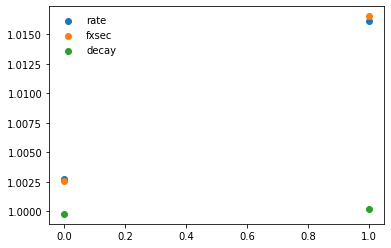

In [13]:
import matplotlib.pyplot as plt

ratios_rate = []
ratios_fxsec = []
ratios_decay = []
for pair in df:
    ratios_rate.append(np.sum(pair[0]['w_event_rate'])/np.sum(pair[1]['w_event_rate']))
    ratios_fxsec.append(np.sum(pair[0]['w_flux_avg_xsec'])/np.sum(pair[1]['w_flux_avg_xsec']))
    
    ratios_decay.append(np.sum(pair[0]['w_decay_rate_0'])/np.sum(pair[1]['w_decay_rate_0']))

plt.scatter(range(2),ratios_rate, label="rate")
plt.scatter(range(2),ratios_fxsec, label="fxsec")
plt.scatter(range(2),ratios_decay, label="decay")
plt.legend(frameon=False)

# plt.scatter(range(0,2),case1, c='blue')
# plt.scatter(range(0,2),case2, c='orange')

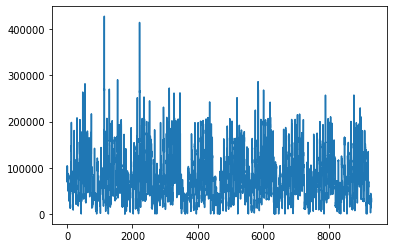

In [14]:
plt.plot(df_1['w_flux_avg_xsec'])
# plt.yscale("log")
# plt.ylim(1,1e7)


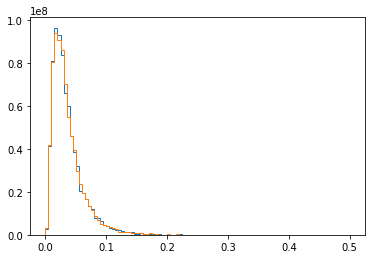

In [15]:
df1,df2 = df[0]
p1 = (df1['P_projectile'] - df1['P_decay_N_parent']).to_numpy()
h1 = dn.Cfourvec.dot4(p1,p1)

p2 = (df2['P_projectile'] - df2['P_decay_N_parent']).to_numpy()
h2 = dn.Cfourvec.dot4(p2,p2)

_ = plt.hist(np.sqrt(-h1), bins=100, range=(0,0.5), histtype='step', weights=df1['w_event_rate'], lw=1)
_ = plt.hist(np.sqrt(-h2), bins=100, range=(0,0.5), histtype='step', weights=df2['w_event_rate'], lw=1)


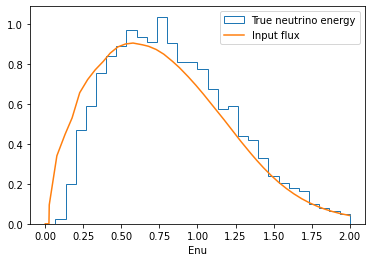

In [16]:
p1 = (df_2['P_projectile']).to_numpy()
# p1 = (df_1['P_decay_ell_minus']+df_1['P_decay_ell_plus']).to_numpy()
# p1 = (df_1['P_decay_ell_minus']+df_1['P_decay_ell_plus']+df_1['P_decay_N_daughter']).to_numpy()
h1 = p1[:,0]
_ = plt.hist(h1, bins=30, histtype='step', range=(0,2), weights=df_2['w_flux_avg_xsec'],density=True, label='True neutrino energy')
plt.xlabel("Enu")
# plt.yscale("log")


x = np.linspace(0,2, 1000)
y = df_1.attrs['experiment'].FLUX_FUNCTIONS[1](x)/( df_1.attrs['experiment'].FLUX_FUNCTIONS[1](x)*(x[1]-x[0])).sum()

plt.plot(x,y, label='Input flux')
plt.legend()

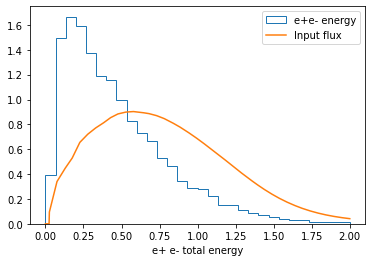

In [18]:

p1 = (df_2['P_decay_ell_minus']+df_2['P_decay_ell_plus']).to_numpy()

h1 = p1[:,0]
_ = plt.hist(h1, bins=30, histtype='step', range=(0,2), weights=df_2['w_event_rate'],density=True, label='e+e- energy')
plt.xlabel("e+ e- total energy")
# plt.yscale("log")


x = np.linspace(0,2, 1000)
y = df_1.attrs['experiment'].FLUX_FUNCTIONS[1](x)/( df_1.attrs['experiment'].FLUX_FUNCTIONS[1](x)*(x[1]-x[0])).sum()

plt.plot(x,y, label='Input flux')
plt.legend()

Text(0.5, 0, 'Enu')

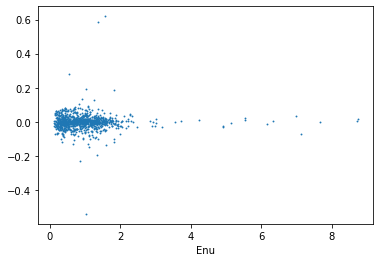

In [129]:
p1 = (df_1['P_projectile']).to_numpy()
x = p1[:,0]
y  = (df_1['P_decay_N_parent']).to_numpy()[:,2]
_ = plt.scatter(x, y, marker='.', s=3,  label='True neutrino energy')
plt.xlabel("Enu")
